# Stock Options Strategies

In [3]:
# @title Configuration

import glob
import warnings
import pandas as pd
import numpy as np
from scipy.stats import norm
import statistics
from dataclasses import dataclass, asdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from typing import List, Dict, Callable
from functools import partial
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from IPython.display import clear_output
from google.colab import drive

##### Configuration #####
drive.mount("/content/drive/")
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("mako")
tqdm.pandas()

##### Constants #####

## Tickers ##
PETR4_TICKER = "PETR4"
VALE3_TICKER = "VALE3"
ITUB4_TICKER = "ITUB4"
BBAS3_TICKER = "BBAS3"
ABEV3_TICKER = "ABEV3"
BBDC4_TICKER = "BBDC4"
BOVA11_TICKER = "BOVA11"

## Data ##
DATA_FOLDER_PATH = "/content/drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options/data/"

### Columns ###
DATE_FEATURE = "date"
# Call price
PREMIUM_FEATURE = "premium"
# How much the stock can fall without profit loss
PREMIUM_PROTECTION_FEATURE = "premium_protection"
CURRENT_STOCK_PRICE_FEATURE = "stock_price"
STRIKE_DATE_FEATURE = "strike_date"
STRIKE_PRICE_FEATURE = "strike_price"
# Strike price divided by the current stock price
STRIKE_MARGIN_FEATURE = "strike_margin"
VOLUME_TRADED_FEATURE = "volume_traded"
HISTORICAL_VOLATILITY_FEATURE = "hist_volatility"
IMPLIED_VOLATILITY_FEATURE = "implied_volatility"
VEGA_FEATURE = "vega"
VOLATILITY_MARGIN_FEATURE = "volatility_margin"
LAST_100_DAYS_MOVING_AVERAGE_FEATURE = "last_100_days_moving_average"
STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE = "stock_price_moving_average_ratio"
LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_30_days_return"
LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_60_days_return"
LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE = "last_90_days_return"
LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE = "last_30_days_max_price_intraday"
# Rate of days the stock price was above the strike price in the last 90 days
STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS = "stock_price_above_strike_price_last_90_days"

### Targets ###
CC_NEXT_MONTH_RETURN_TARGET = "cc_next_month_return"
NEXT_MONTH_BUY_AND_HOLD_RETURN_TARGET = "next_month_buy_and_hold_return"
CC_BETTER_THAN_BUY_AND_HOLD_TARGET = "cc_better_than_buy_and_hold"
CC_BETTER_THAN_BUY_AND_HOLD_AMOUNT_TARGET = "cc_better_than_buy_and_hold_amount"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# @title Load Features

stock_df_map = {}
call_feature_df_map = {}

for ticker in [
    PETR4_TICKER,
    VALE3_TICKER,
    ITUB4_TICKER,
    BBAS3_TICKER,
    ABEV3_TICKER,
    BBDC4_TICKER,
    BOVA11_TICKER,
]:  

    stock_df_map[ticker] = pd.read_csv(
        DATA_FOLDER_PATH + f"processed_data/{ticker.lower()}_stock.csv",
        parse_dates=["data_pregao"], date_parser=lambda date_str: datetime.strptime(date_str, "%Y-%m-%d")
    )
    call_feature_df_map[ticker] = pd.read_csv(
        DATA_FOLDER_PATH + f"final_data/{ticker.lower()}_features.csv",
        parse_dates=[DATE_FEATURE, STRIKE_DATE_FEATURE],
        date_parser=lambda date_str: datetime.strptime(date_str, "%Y-%m-%d")
    )

## Covered Call Strategy
The strategies we're going to simulate here are based in the European Covered Call strategy.
The idea is to by the stock and sell a call option for this asset with strike price higher than the stock price.
Two cases can happen at the expiration date:
* The stock price will be lower than the strike price at the expiration date. In this case the call turns to dust and we keep the stock and the premium.
* The stock price will be higher than the strike price. This mean we have to sell the stock by the strike price which bounds our profit.

To avoid code duplication and to keep the code cleaner, we'll implement the **strategy pattern** for the different covered call strategies. For the time being, the only between them is the way we pick the call option. Then, we will encapsulate what changes. 

In [4]:
initial_amount = 100_000.0
volume_threshold = 1000
min_date = datetime(year=2022, month=1, day=1)
max_date = datetime(year=2022, month=10, day=31)
simulation_dates = call_feature_df_map[PETR4_TICKER][
    (call_feature_df_map[PETR4_TICKER][STRIKE_DATE_FEATURE] >= min_date)
    & (call_feature_df_map[PETR4_TICKER][STRIKE_DATE_FEATURE] <= max_date)
][STRIKE_DATE_FEATURE].unique()
simulation_dates.sort()

##### ML Variables #####
strike_margin_threshold = 0.1
max_days_to_strike = 40

In [5]:
# @title Shared

########## Exceptions ##########

class NoCompatibleCallOptionException(Exception):
    pass

class NoNegociationsOnDate(Exception):
    pass

########## Abstractions ##########
abstract_pick_call_strategy = Callable[
    [
        pd.DataFrame, # stock_df
        pd.DataFrame, # call_df
        datetime, # current_date
        datetime, # expiration_date
    ],
    pd.Series # call_option
] # Throws NoCompatibleCallOptionException

########## Schemas ##########

@dataclass
class CoveredCallResults:
  initial_amount: float
  final_amount: float
  total_return: float
  strike_number: int # Number of times the stock price reached the strike price
  months_without_selling: int # Number of months where we couldn't find a proper call option
  average_strike_margin: float
  sd_strike_margin: float
  patrimony_over_time: List[float]

########## Utils ##########

def get_stock_price(
    stock_df: pd.DataFrame,
    date: datetime
) -> float:
    stock_price = stock_df[stock_df["data_pregao"] == date]["preco_ultimo_negocio"]
    if stock_price.shape[0] == 0: raise NoNegociationsOnDate(f"No negociations on date: {date}")
    return stock_price.iloc[0]

def simulate_covered_call(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    initial_amount: float,
    dates: List[datetime],
    pick_call_strategy: abstract_pick_call_strategy
) -> CoveredCallResults:

    amount_available = initial_amount
    n_stocks = 0
    strike_number = 0
    months_without_selling = 0
    strike_margins = []
    patrimony_over_time = []

    for i in tqdm(range(len(dates)-1), leave=False):
        ### Beginning of the cycle ###
        # Buy as many stocks as possible with the available amount
        try:
            price = stock_df[stock_df["data_pregao"] == dates[i]]["preco_ultimo_negocio"].iloc[0]
        except Exception as e:
            continue

        n_new_stocks = math.floor(amount_available/price)
        n_stocks += n_new_stocks
        amount_available -= n_new_stocks * price
        patrimony_over_time.append(amount_available + (n_stocks * price))

        try:
            call_option = pick_call_strategy(
                stock_df,
                call_df,
                dates[i],
                dates[i+1],
            )
        except NoCompatibleCallOptionException as e:
            months_without_selling += 1
            continue

        # Acumulate the strike margins
        strike_margins.append(100 * (call_option[STRIKE_PRICE_FEATURE] - price) / price)
        # Sell the call option
        amount_available += n_stocks * call_option[PREMIUM_FEATURE]

        ### End of the cycle ###
        price = stock_df[stock_df["data_pregao"] == dates[i+1]]["preco_ultimo_negocio"].iloc[0]
        # If the stock price goes above the strike price, we are striked
        if price > call_option[STRIKE_PRICE_FEATURE]:
            # We have to sell all stocks by the strike price
            amount_available += n_stocks * call_option[STRIKE_PRICE_FEATURE]
            n_stocks = 0
            strike_number += 1

    patrimony_over_time.append(amount_available + (n_stocks * stock_df[stock_df["data_pregao"] == dates[-1]]["preco_ultimo_negocio"].iloc[0]))
    return CoveredCallResults(
        initial_amount=initial_amount,
        final_amount=patrimony_over_time[-1],
        total_return=(patrimony_over_time[-1] - initial_amount)/initial_amount,
        strike_number=strike_number,
        months_without_selling=months_without_selling,
        average_strike_margin=statistics.mean(strike_margins) if len(strike_margins) > 1 else -1,
        sd_strike_margin=statistics.stdev(strike_margins) if len(strike_margins) > 1 else -1,
        patrimony_over_time=patrimony_over_time
    )

### Covered Call with Fixed Strike Margins

In [6]:
# @title Functions

def pick_call_strike_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,

    volume_threshold: int,
    strike_margin: float,
    strike_margin_tolerance: float
) -> pd.Series:
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)
    target_strike_price = stock_price * (1+strike_margin)

    # Filter call options traded at the current data and expire the next date
    # that have enough negotiations
    filtered_call_df = call_df[
        # Traded at the current data
        (call_df[DATE_FEATURE] == current_date)
        # Expire at the right expiration date
        & (call_df[STRIKE_DATE_FEATURE] == expiration_date)
        # Have enough negotiations at the current date
        & (call_df[VOLUME_TRADED_FEATURE] >= volume_threshold)
        # Have strike price inside target_strike_price +- strike_margin_tolerance*stock_price
        & ((call_df[STRIKE_PRICE_FEATURE] - target_strike_price).abs() <= strike_margin_tolerance*stock_price)
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(
            f"No option found at: {current_date} that expires at: {expiration_date}"
        )

    return filtered_call_df.loc[filtered_call_df[PREMIUM_FEATURE].idxmax()]


From: 2022-01-21T00:00:00.000000000 to 2022-10-21T00:00:00.000000000 / 10



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

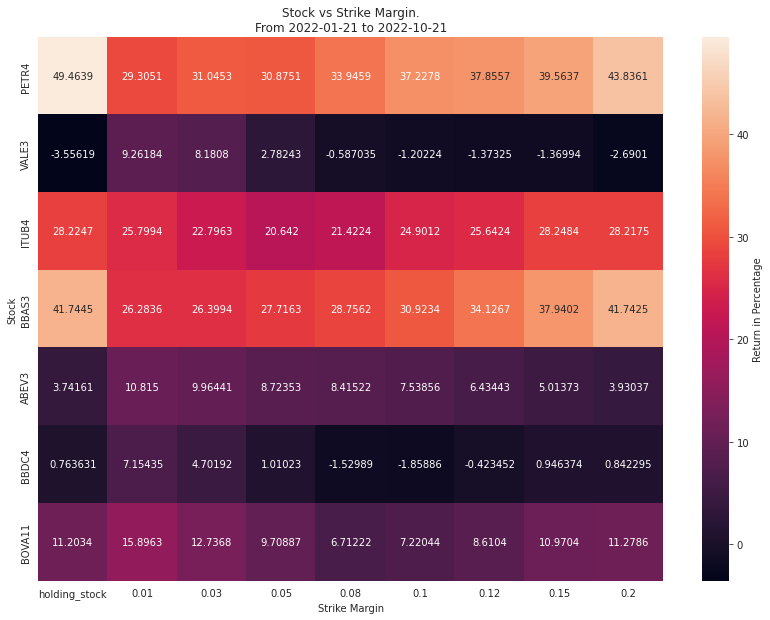

In [7]:
# @title Simulation

strike_margin_tolerance = 0.01
strike_margins = [0.01, 0.03, 0.05, 0.08, 0.10, 0.12, 0.15, 0.20]
print(f"From: {simulation_dates.min()} to {simulation_dates.max()} / {len(simulation_dates)}\n")

fixed_strike_cov_call_results_dict = {k: {} for k in stock_df_map.keys()}

for ticker, stock_df in stock_df_map.items():
    initial_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[0]
    )
    final_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[-1]
    )
    fixed_strike_cov_call_results_dict[ticker]["holding_stock"] = (
        final_price - initial_price
    )/initial_price

outer_progress_bar = tqdm(strike_margins, leave=False)
for strike_margin in outer_progress_bar:
    outer_progress_bar.set_description(f"Strike margin at {100*strike_margin:.2f}%")

    pick_call_strategy=partial(
        pick_call_strike_margin_strategy,
        volume_threshold=volume_threshold,
        strike_margin=strike_margin,
        strike_margin_tolerance=strike_margin_tolerance
    )

    inner_progress_bar = tqdm(stock_df_map.keys(), leave=False)
    for ticker in inner_progress_bar:
        inner_progress_bar.set_description(ticker)

        results = simulate_covered_call(
            stock_df=stock_df_map[ticker],
            call_df=call_feature_df_map[ticker],
            initial_amount=initial_amount,
            dates=simulation_dates,
            pick_call_strategy=pick_call_strategy
        )
        fixed_strike_cov_call_results_dict[ticker][strike_margin] = results.total_return

##### Plot the results #####
plt.figure(figsize=(14, 10))

plt.title(f"Stock vs Strike Margin.\nFrom {pd.to_datetime(simulation_dates[0]).date()} to {pd.to_datetime(simulation_dates[-1]).date()}")

sns.heatmap(
    pd.DataFrame(fixed_strike_cov_call_results_dict).transpose()*100,
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Return in Percentage'},
    # vmin=0,
    # vmax=200
)
plt.ylabel("Stock")
_ = plt.xlabel("Strike Margin")

### Covered Call with Fixed Volatility Margins

Here we'll use the volatility as a measure to pick the best call option in a given month

In [8]:
#@title Functions
def pick_call_closest_volatility_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,
    volatility_margin: float,
    last_n_working_days: int,
    strike_margin_threshold: float,
) -> pd.Series:
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)
    # hist_volatility = annualized_hist_volatility(stock_df, end_date=current_date, offset=last_n_working_days)

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df["data_pregao"] == current_date)
        & (call_df["data_vencimento"] == expiration_date)
        & (call_df["preco_exercicio"] > stock_price * (1 + strike_margin_threshold))
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    call_volatility_margin_distances = (filtered_call_df[VOLATILITY_MARGIN_FEATURE] - volatility_margin).abs()

    call_df = call_df.filter(items = call_volatility_margin_distances.index, axis=0)
    min_distance_idx = call_volatility_margin_distances.idxmin()

    return call_df.loc[min_distance_idx]

def pick_call_volatility_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,
    volatility_margin: float,
    last_n_working_days: int,
    strike_margin_threshold: float,
    tolerance: float,
) -> pd.Series:
    """
    Pick the call option in `call_df` that has implied volatility higher than the historical one
    by approximately `volatility_margin`%.
    We only consider call options that have volatility margin inside the range
    [volatility_margin - tolerance, volatility_margin + tolerance]. If more than one call is found,
    we take the one with highest premium.
    """
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df[DATE_FEATURE] == current_date)
        & (call_df[STRIKE_DATE_FEATURE] == expiration_date)
        & (call_df[STRIKE_MARGIN_FEATURE] > strike_margin_threshold)
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    call_volatility_margin_distances = (filtered_call_df[VOLATILITY_MARGIN_FEATURE] - volatility_margin).abs()
    # Remove call options that have volatility margin too far from the target 
    call_volatility_margin_distances = call_volatility_margin_distances[call_volatility_margin_distances < tolerance]
    
    if(call_volatility_margin_distances.size == 0):
      raise NoCompatibleCallOptionException(f"No call option found for the volatility margin: {volatility_margin}")
    call_df_ = call_df.filter(items = call_volatility_margin_distances.index, axis=0)
    max_premium_idx = call_df_[PREMIUM_FEATURE].idxmax()

    return call_df_.loc[max_premium_idx]


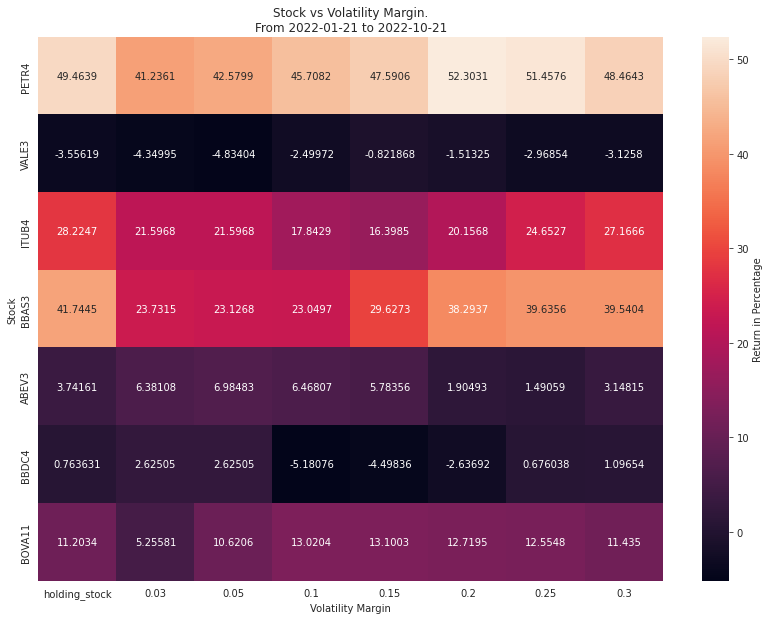

In [9]:
# @title Simulation

volatility_margins = [0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
last_n_working_days = 60
strike_margin_threshold = 0.05
tolerance = 0.05
print(f"From: {simulation_dates.min()} to {simulation_dates.max()}\n")

fixed_vol_margin_cov_call_results_dict = {k: {} for k in stock_df_map.keys()}

for ticker, stock_df in stock_df_map.items():
    initial_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[0]
    )
    final_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[-1]
    )
    fixed_vol_margin_cov_call_results_dict[ticker]["holding_stock"] = (
        final_price - initial_price
    )/initial_price

outer_progress_bar = tqdm(volatility_margins, leave=False)
for vol_margin in outer_progress_bar:
    outer_progress_bar.set_description(f"Vol margin at {100*vol_margin:.2f}%")

    pick_call_vol_strategy = partial(
        pick_call_volatility_margin_strategy,
        volatility_margin=vol_margin,
        last_n_working_days=last_n_working_days,
        strike_margin_threshold=strike_margin_threshold,
        tolerance=tolerance,
    )

    inner_progress_bar = tqdm(stock_df_map.keys(), leave=False)
    for ticker in inner_progress_bar:
        inner_progress_bar.set_description(ticker)

        results = simulate_covered_call(
            stock_df=stock_df_map[ticker],
            call_df=call_feature_df_map[ticker],
            initial_amount=initial_amount,
            dates=simulation_dates,
            pick_call_strategy=pick_call_vol_strategy
        )
        fixed_vol_margin_cov_call_results_dict[ticker][vol_margin] = results.total_return


##### Plot the results #####
clear_output(wait=False)
plt.figure(figsize=(14, 10))

plt.title(f"Stock vs Volatility Margin.\nFrom {pd.to_datetime(simulation_dates[0]).date()} to {pd.to_datetime(simulation_dates[-1]).date()}")

sns.heatmap(
    pd.DataFrame(fixed_vol_margin_cov_call_results_dict).transpose()*100,
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Return in Percentage'},
    # vmin=0,
    # vmax=200
)
plt.ylabel("Stock")
_ = plt.xlabel("Volatility Margin")

### Adaptative Covered Call

In [83]:
# @title Functions

def predict(
    pipeline: Pipeline,
    call_features: pd.Series
) -> float:
    try:
        return pipeline.predict_proba([call_features.to_list()])[0][1]
    except Exception as e:
      return pipeline.predict([call_features.to_list()], verbose=False)[0][0] # For NNs

def pick_call_ml_classification_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,

    pipeline: Pipeline,
    features: List[str],
    proba_tolerance: float,
) -> pd.Series:

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df[DATE_FEATURE] == current_date)
        & (call_df[STRIKE_DATE_FEATURE] == expiration_date)
        & (call_df[STRIKE_MARGIN_FEATURE] > 0)
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    call_profit_probabilities = filtered_call_df.apply(lambda call_option:
        predict(
            call_features=call_option[features],
            pipeline=pipeline
        ),
        axis=1
    )
    
    call_profit_probabilities = call_profit_probabilities[call_profit_probabilities > proba_tolerance]
    if(call_profit_probabilities.size == 0):
      raise NoCompatibleCallOptionException(f"No call option found for the probability tolerance: {proba_tolerance}")

    call_df_ = call_df.filter(items = call_profit_probabilities.index, axis=0)
    max_premium_idx = call_df_[PREMIUM_FEATURE].idxmax()

    return call_df_.loc[max_premium_idx]

#### Logistic Regression Covered Call

Logistic Regression Accuracies



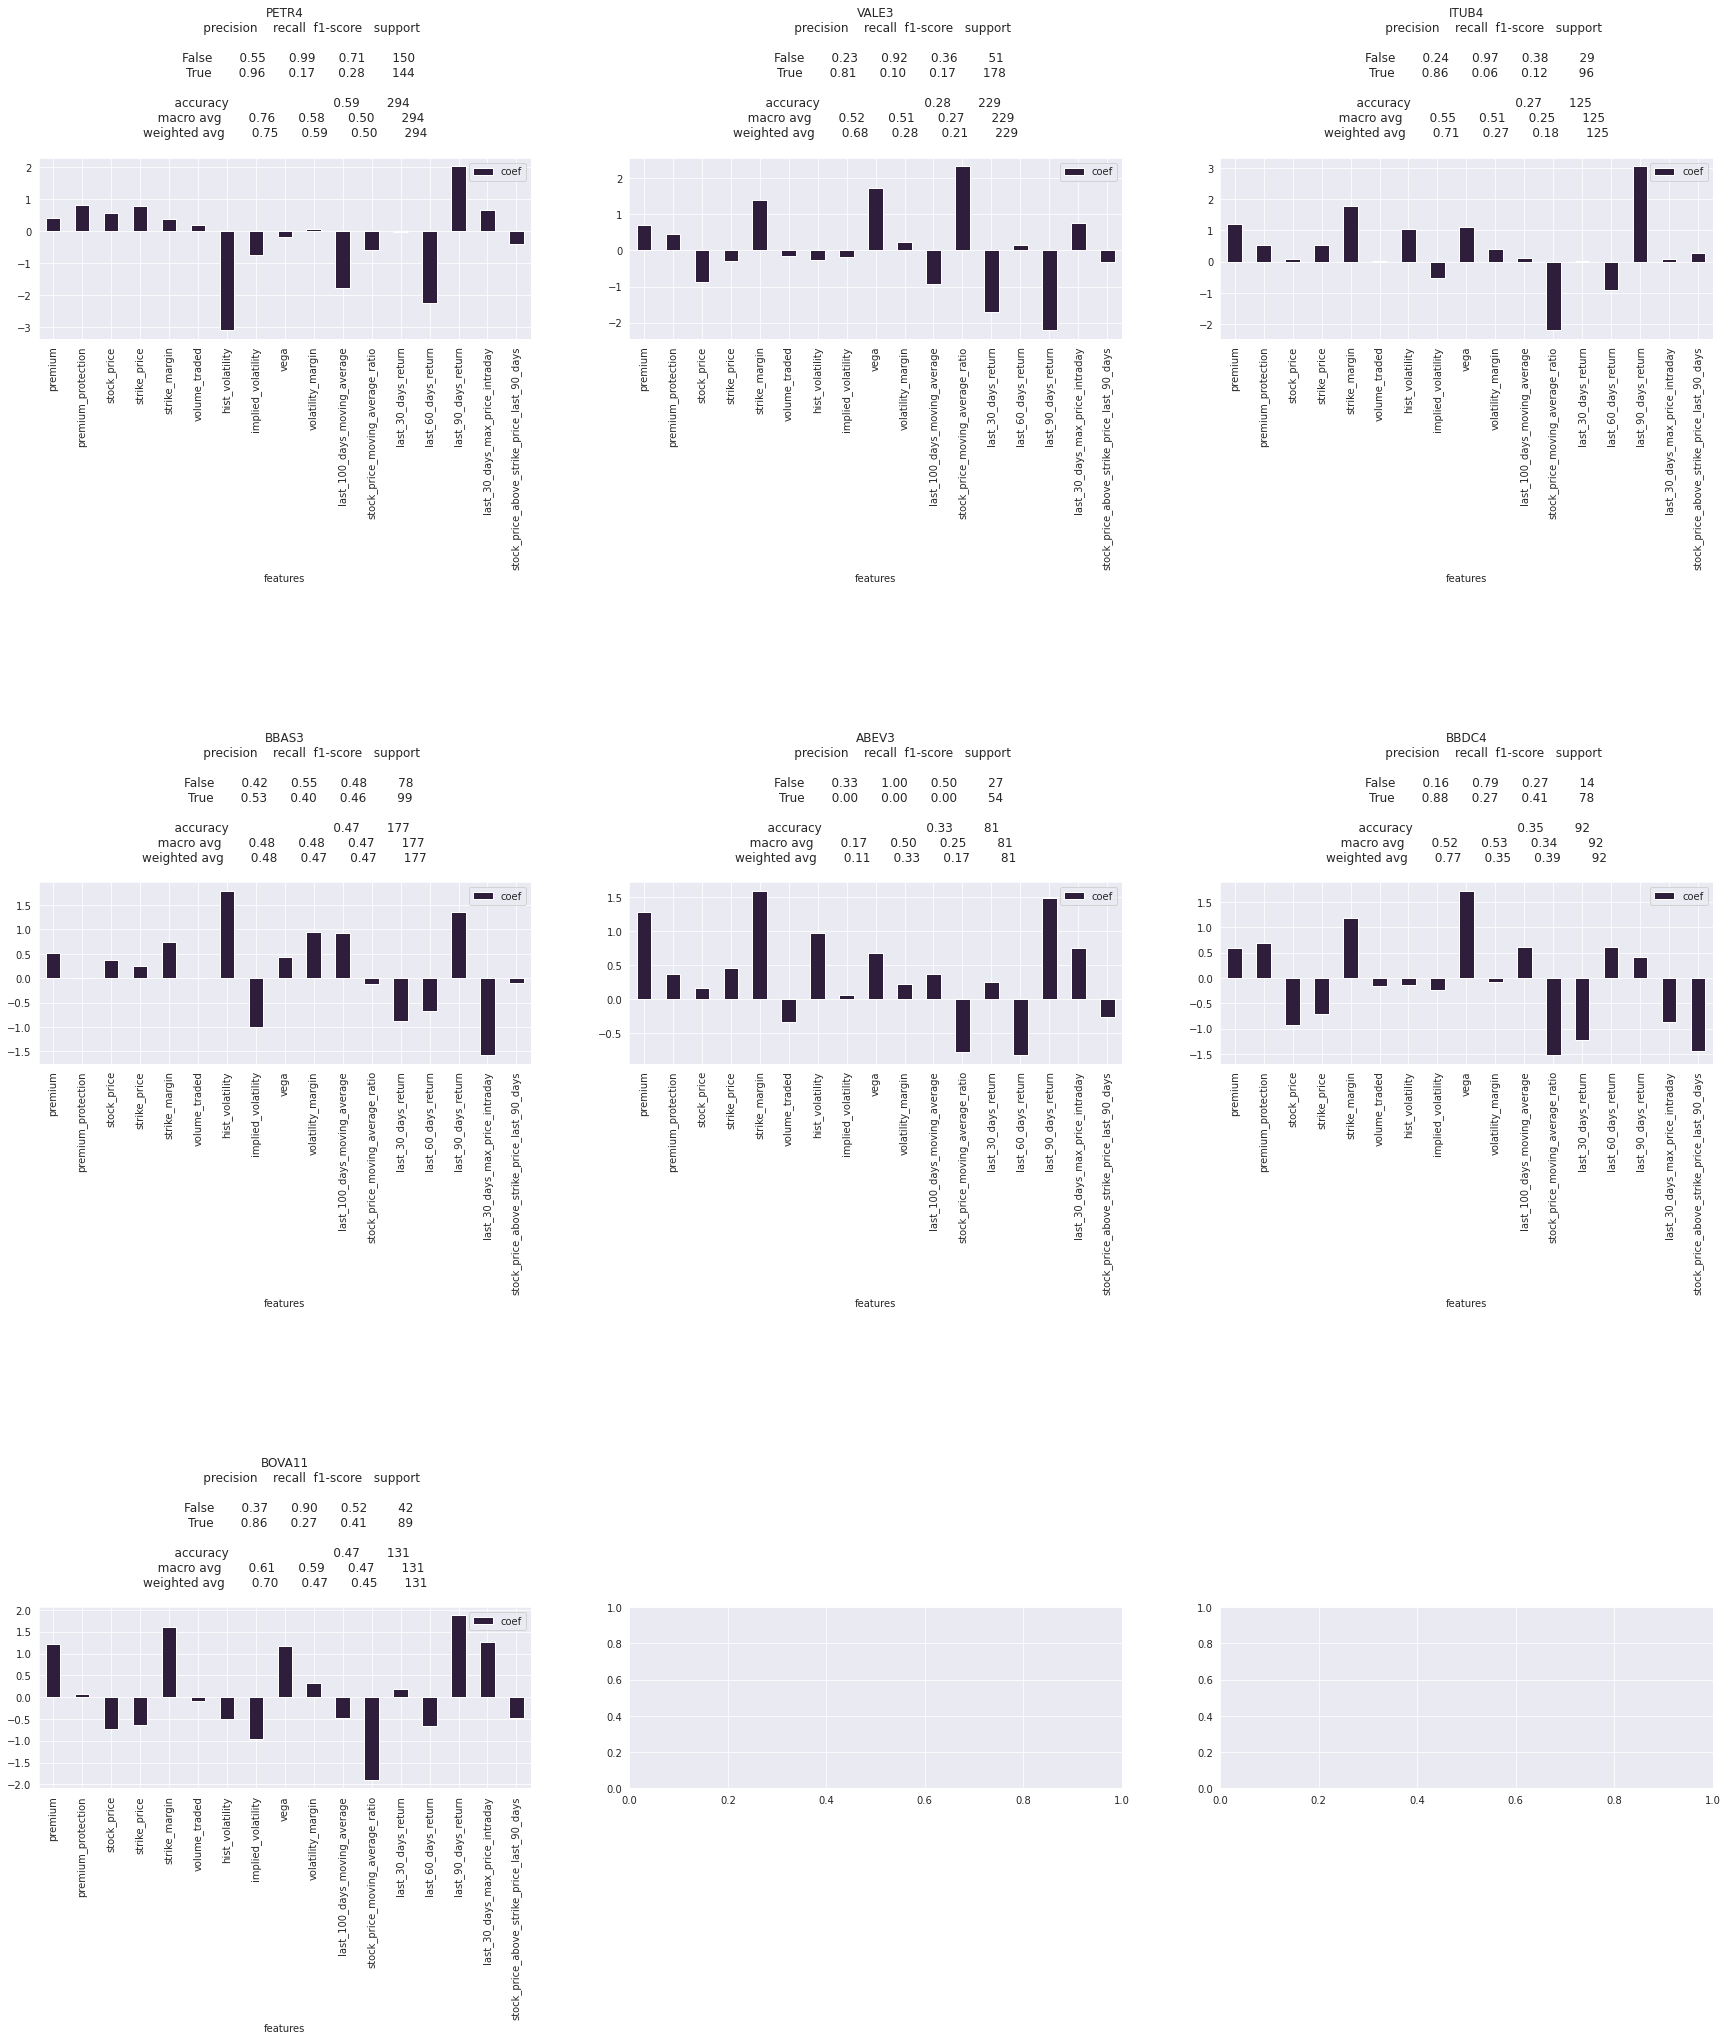

In [52]:
# @title Model

ll_features = [
    PREMIUM_FEATURE,
    PREMIUM_PROTECTION_FEATURE,
    CURRENT_STOCK_PRICE_FEATURE,
    STRIKE_PRICE_FEATURE,
    STRIKE_MARGIN_FEATURE,
    HISTORICAL_VOLATILITY_FEATURE,
    IMPLIED_VOLATILITY_FEATURE,
    VEGA_FEATURE,
    VOLATILITY_MARGIN_FEATURE,
    LAST_100_DAYS_MOVING_AVERAGE_FEATURE,
    STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE,
    LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE,
    STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS,
]
ll_target = [CC_BETTER_THAN_BUY_AND_HOLD_TARGET]
ll_prob_threshold = 0.8
ll_pipeline_map = {}

print(f"Logistic Regression Accuracies\n")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30,30))
plt.subplots_adjust(
    hspace=3
)
plt_idx = 0
for ticker, ml_df in call_feature_df_map.items():

    ### Filter call by strike margin and time to expire ###
    ml_df_ = ml_df[
        (ml_df[STRIKE_MARGIN_FEATURE] <= strike_margin_threshold)
        & (
            ((ml_df[STRIKE_DATE_FEATURE]-ml_df[DATE_FEATURE])
            - timedelta(days=max_days_to_strike)) <= timedelta(days=0)
          )
    ]

    ### Split train and test data ###
    test_size = 1 - (
        ml_df_[ml_df_["date"] < min_date].size/ml_df_.size
    )
    X_train, X_test, y_train, y_test = train_test_split(
        ml_df_[ll_features],
        ml_df_[ll_target],
        test_size=test_size,
        shuffle=False
    )

    ### Build and train the model ###
    steps = [
        ("scale", StandardScaler()),
        ("logistic_regresstion", LogisticRegression(random_state=42))
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    ll_pipeline_map[ticker] = pipeline

    ### Display the results ###
    # Precision: What percent of your predictions were correct?
    # Precision is the ability of a classifier not to label an instance positive that is actually negative
    y_pred = pipeline.predict_proba(X_test)[:,1] > ll_prob_threshold
    pd.DataFrame(
        zip(X_train.columns, np.transpose(pipeline.steps[1][1].coef_[0])),
        columns=['features', 'coef']
    ).plot(
        x="features",
        y="coef",
        kind="bar",
        title=f"{ticker}\n{classification_report(y_test, y_pred)}",
        ax=axes[int(plt_idx/3), plt_idx%3]
    )
    plt_idx += 1

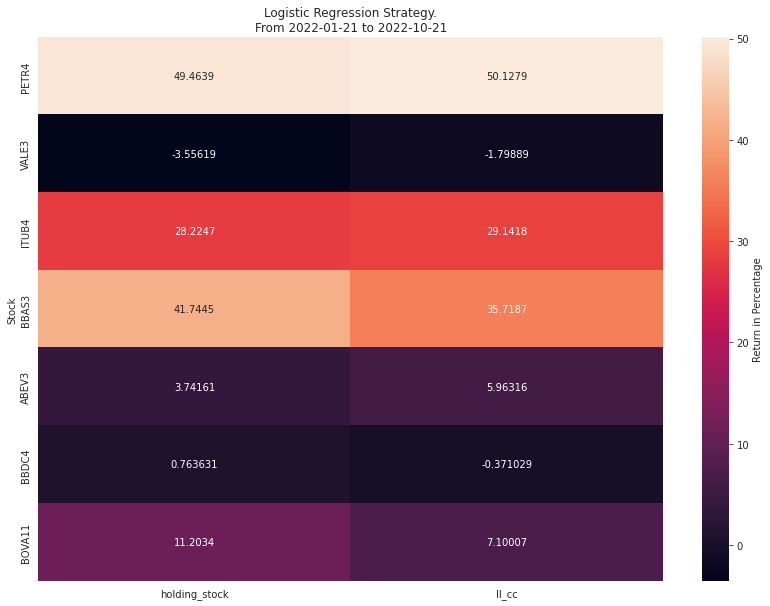

In [53]:
# @title Simulation

### Variables ###
print(f"From: {simulation_dates.min()} to {simulation_dates.max()}\n")
PROBABILITY_THRESHOLD=0.95

### Simulation ###

ll_cov_call_results_dict = {k: {} for k in stock_df_map.keys()}

for ticker, stock_df in stock_df_map.items():
    initial_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[0]
    )
    final_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[-1]
    )
    ll_cov_call_results_dict[ticker]["holding_stock"] = (
        final_price - initial_price
    )/initial_price

progress_bar = tqdm(stock_df_map.keys(), leave=False)
for ticker in progress_bar:
    progress_bar.set_description(ticker)

    pick_call_ml_strategy = partial(
        pick_call_ml_classification_strategy,
        pipeline=ll_pipeline_map[ticker],
        features=ll_features,
        proba_tolerance=ll_prob_threshold,
    )

    results = simulate_covered_call(
        stock_df=stock_df_map[ticker],
        call_df=call_feature_df_map[ticker],
        initial_amount=initial_amount,
        dates=simulation_dates,
        pick_call_strategy=pick_call_ml_strategy
    )

    ll_cov_call_results_dict[ticker]["ll_cc"] = results.total_return

##### Plot the results #####
clear_output(wait=False)
plt.figure(figsize=(14, 10))

plt.title(f"Logistic Regression Strategy.\nFrom {pd.to_datetime(simulation_dates[0]).date()} to {pd.to_datetime(simulation_dates[-1]).date()}")

sns.heatmap(
    pd.DataFrame(ll_cov_call_results_dict).transpose()*100,
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Return in Percentage'},
    # vmin=0,
    # vmax=200
)
_ = plt.ylabel("Stock")

#### Random Forest Covered Call

In [73]:
# @title Model

rf_features = [
    # PREMIUM_FEATURE,
    PREMIUM_PROTECTION_FEATURE,
    CURRENT_STOCK_PRICE_FEATURE,
    # STRIKE_PRICE_FEATURE,
    STRIKE_MARGIN_FEATURE,
    HISTORICAL_VOLATILITY_FEATURE,
    # IMPLIED_VOLATILITY_FEATURE,
    # VEGA_FEATURE,
    # VOLATILITY_MARGIN_FEATURE,
    # LAST_100_DAYS_MOVING_AVERAGE_FEATURE,
    STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE,
    LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE,
    STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS,
]
rf_target = [CC_BETTER_THAN_BUY_AND_HOLD_TARGET]
rf_prob_threshold = 0.8
rf_pipeline_map = {}

print(f"Random Forest Accuracies\n")
for ticker, ml_df in call_feature_df_map.items():

    ### Filter call by strike margin and time to expire ###
    ml_df_ = ml_df[
        (ml_df[STRIKE_MARGIN_FEATURE] <= strike_margin_threshold)
        & (
            ((ml_df[STRIKE_DATE_FEATURE]-ml_df[DATE_FEATURE])
            - timedelta(days=max_days_to_strike)) <= timedelta(days=0)
          )
    ]

    ### Split train and test data ###
    test_size = 1 - (
        ml_df_[ml_df_["date"] < min_date].size/ml_df_.size
    )
    X_train, X_test, y_train, y_test = train_test_split(
        ml_df_[rf_features],
        ml_df_[rf_target],
        test_size=test_size,
        shuffle=False
    )

    ### Build and train the model ###
    steps = [
        ("scale", StandardScaler()),
        ("rand_forest", RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5))
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    rf_pipeline_map[ticker] = pipeline


    ### Results ###
    print("===================================================================")
    print(f"Train Accuracy: {ticker}: {100*metrics.accuracy_score(y_train, pipeline.predict(X_train)):.2f}%")
    print(f"Test Accuracy: {ticker}: {100*metrics.accuracy_score(y_test, pipeline.predict(X_test)):.2f}%\n")
    y_pred = pipeline.predict_proba(X_test)[:,1] > rf_prob_threshold
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

Random Forest Accuracies

Train Accuracy: PETR4: 96.20%
Test Accuracy: PETR4: 37.41%

              precision    recall  f1-score   support

       False       0.27      0.13      0.18       150
        True       0.41      0.62      0.49       144

    accuracy                           0.37       294
   macro avg       0.34      0.38      0.34       294
weighted avg       0.34      0.37      0.33       294

Train Accuracy: VALE3: 95.73%
Test Accuracy: VALE3: 60.26%

              precision    recall  f1-score   support

       False       0.34      0.86      0.49        51
        True       0.93      0.53      0.67       178

    accuracy                           0.60       229
   macro avg       0.64      0.70      0.58       229
weighted avg       0.80      0.60      0.63       229

Train Accuracy: ITUB4: 97.50%
Test Accuracy: ITUB4: 44.00%

              precision    recall  f1-score   support

       False       0.25      0.69      0.36        29
        True       0.80      0.

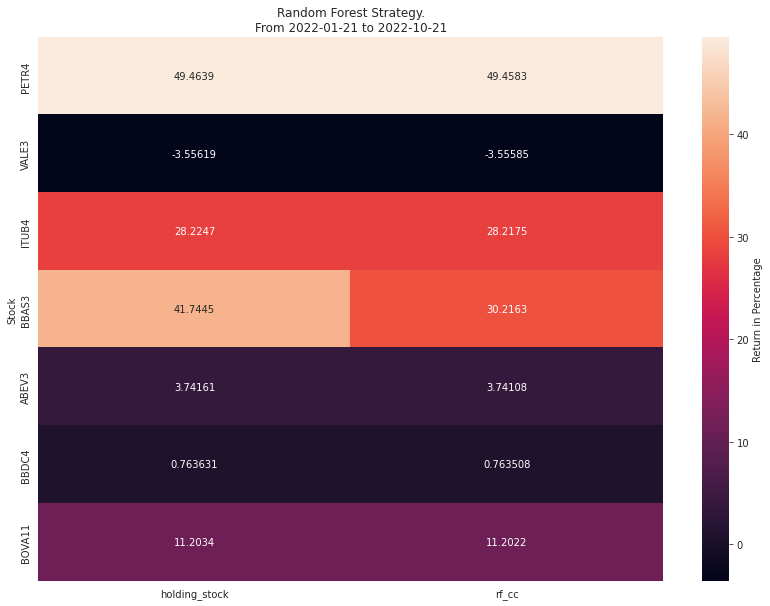

In [69]:
# @title Simulation

### Variables ###
print(f"From: {simulation_dates.min()} to {simulation_dates.max()}\n")
PROBABILITY_THRESHOLD=0.7

### Simulation ###

rf_cov_call_results_dict = {k: {} for k in stock_df_map.keys()}

for ticker, stock_df in stock_df_map.items():
    initial_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[0]
    )
    final_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[-1]
    )
    rf_cov_call_results_dict[ticker]["holding_stock"] = (
        final_price - initial_price
    )/initial_price

progress_bar = tqdm(stock_df_map.keys(), leave=False)
for ticker in progress_bar:
    progress_bar.set_description(ticker)

    pick_call_ml_strategy = partial(
        pick_call_ml_classification_strategy,
        pipeline=rf_pipeline_map[ticker],
        features=rf_features,
        proba_tolerance=rf_prob_threshold,
    )

    results = simulate_covered_call(
        stock_df=stock_df_map[ticker],
        call_df=call_feature_df_map[ticker],
        initial_amount=initial_amount,
        dates=simulation_dates,
        pick_call_strategy=pick_call_ml_strategy
    )

    rf_cov_call_results_dict[ticker]["rf_cc"] = results.total_return

##### Plot the results #####
clear_output(wait=False)
plt.figure(figsize=(14, 10))

plt.title(f"Random Forest Strategy.\nFrom {pd.to_datetime(simulation_dates[0]).date()} to {pd.to_datetime(simulation_dates[-1]).date()}")

sns.heatmap(
    pd.DataFrame(rf_cov_call_results_dict).transpose()*100,
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Return in Percentage'},
    # vmin=0,
    # vmax=200
)
_ = plt.ylabel("Stock")

#### Neural Network Covered Call

In [77]:
# @title Model

nn_features = [
    PREMIUM_FEATURE,
    PREMIUM_PROTECTION_FEATURE,
    CURRENT_STOCK_PRICE_FEATURE,
    STRIKE_PRICE_FEATURE,
    STRIKE_MARGIN_FEATURE,
    HISTORICAL_VOLATILITY_FEATURE,
    IMPLIED_VOLATILITY_FEATURE,
    VEGA_FEATURE,
    VOLATILITY_MARGIN_FEATURE,
    LAST_100_DAYS_MOVING_AVERAGE_FEATURE,
    STOCK_PRICE__MOVING_AVERAGE__RATIO_FEATURE,
    LAST_30_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_60_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_90_DAYS_BUY_AND_HOLD_RETURN_FEATURE,
    LAST_100_DAYS_MAX_PRICE_INTRADAY_FEATURE,
    STOCK_PRICE_ABOVE_STRIKE_PRICE_LAST_90_DAYS,
]
nn_target = [CC_BETTER_THAN_BUY_AND_HOLD_TARGET]
number_of_epochs = 400
early_stopping_patience = 20
nn_prob_threshold = 0.8
nn_pipeline_map = {}

for ticker, ml_df in call_feature_df_map.items():

    ### Filter call by strike margin and time to expire ###
    ml_df_ = ml_df[
        (ml_df[STRIKE_MARGIN_FEATURE] <= strike_margin_threshold)
        & (
            ((ml_df[STRIKE_DATE_FEATURE]-ml_df[DATE_FEATURE])
            - timedelta(days=max_days_to_strike)) <= timedelta(days=0)
          )
    ]

    ##### Split the data #####
    test_size = 1 - (
        ml_df_[ml_df_["date"] < min_date].size/ml_df_.size
    )
    X_train, X_test, y_train, y_test = train_test_split(
        ml_df_[nn_features],
        ml_df_[nn_target],
        test_size=test_size,
        shuffle=False
    )

    ##### Define the NN #####
    kernel_regularizer=keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Dense(16, input_shape=(len(nn_features),), activation="relu", kernel_regularizer=kernel_regularizer))
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(16, activation="relu", kernel_regularizer=kernel_regularizer),)
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    ##### Define the pipeline #####
    steps = [
        ("scale", StandardScaler()),
        ("neural_network", model)
    ]
    pipeline = Pipeline(steps)

    ##### Train and evaluate #####
    pipeline.fit(
        X_train,
        y_train,
        neural_network__epochs=number_of_epochs,
        neural_network__batch_size=10,
        neural_network__callbacks=[EarlyStopping(monitor="accuracy", patience=early_stopping_patience)],
        neural_network__verbose=False,
    )
    nn_pipeline_map[ticker] = pipeline

    ### Classification ###
    y_pred = pipeline.predict(X_test) > nn_prob_threshold
    print("===================================================================")
    print(ticker)
    print(f"\nTest size: {100*test_size:.2f}%")
    print(classification_report(y_test, y_pred))
    print()

10/10 [==============================] - 0s 1ms/step
PETR4

Test size: 23.19%
              precision    recall  f1-score   support

       False       0.52      0.79      0.63       150
        True       0.53      0.25      0.34       144

    accuracy                           0.52       294
   macro avg       0.53      0.52      0.48       294
weighted avg       0.53      0.52      0.49       294


8/8 [==============================] - 0s 2ms/step
VALE3

Test size: 20.46%
              precision    recall  f1-score   support

       False       0.53      0.96      0.68        51
        True       0.99      0.75      0.85       178

    accuracy                           0.80       229
   macro avg       0.76      0.86      0.77       229
weighted avg       0.88      0.80      0.81       229


4/4 [==============================] - 0s 3ms/step
ITUB4

Test size: 19.22%
              precision    recall  f1-score   support

       False       0.24      0.93      0.38        29
     

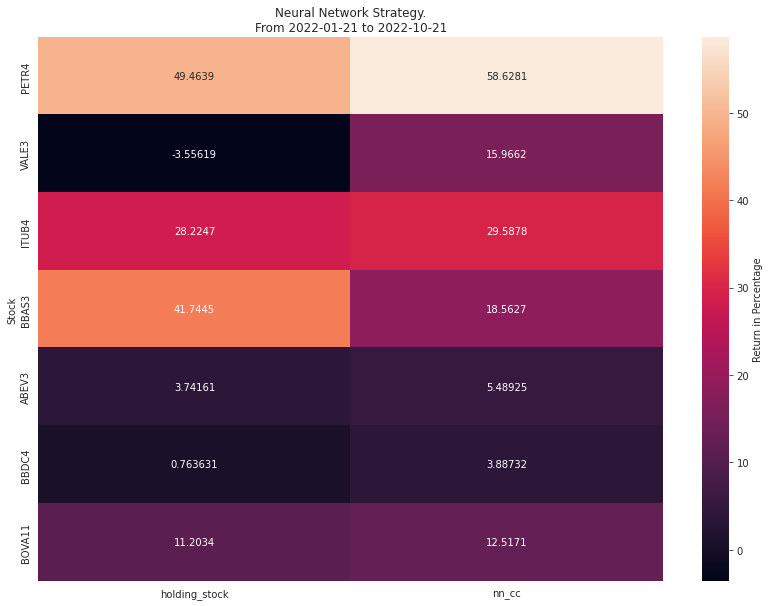

In [84]:
# @title Simulation

### Variables ###
print(f"From: {simulation_dates.min()} to {simulation_dates.max()}\n")

### Simulation ###

nn_cov_call_results_dict = {k: {} for k in stock_df_map.keys()}

for ticker, stock_df in stock_df_map.items():
    initial_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[0]
    )
    final_price = get_stock_price(
        stock_df=stock_df,
        date=simulation_dates[-1]
    )
    nn_cov_call_results_dict[ticker]["holding_stock"] = (
        final_price - initial_price
    )/initial_price

progress_bar = tqdm(stock_df_map.keys(), leave=False)
for ticker in progress_bar:
    progress_bar.set_description(ticker)

    pick_call_ml_strategy = partial(
        pick_call_ml_classification_strategy,
        pipeline=nn_pipeline_map[ticker],
        features=nn_features,
        proba_tolerance=rf_prob_threshold,
    )

    results = simulate_covered_call(
        stock_df=stock_df_map[ticker],
        call_df=call_feature_df_map[ticker],
        initial_amount=initial_amount,
        dates=simulation_dates,
        pick_call_strategy=pick_call_ml_strategy
    )

    nn_cov_call_results_dict[ticker]["nn_cc"] = results.total_return

##### Plot the results #####
clear_output(wait=False)
plt.figure(figsize=(14, 10))

plt.title(f"Neural Network Strategy.\nFrom {pd.to_datetime(simulation_dates[0]).date()} to {pd.to_datetime(simulation_dates[-1]).date()}")

sns.heatmap(
    pd.DataFrame(nn_cov_call_results_dict).transpose()*100,
    annot=True,
    fmt='g',
    cbar_kws={'label': 'Return in Percentage'},
    # vmin=0,
    # vmax=200
)
_ = plt.ylabel("Stock")

In [ ]:
%cd drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options/
!git config --global user.email "luikymagno@gmail.com"
!git config --global user.name "luikymagno"

!git add -A
!git commit -m "UPDATE: Separete notebooks"
!git push

/content/drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options
